# Vorlesung: Agenten-basiertes Modellieren

In [1]:
%matplotlib notebook

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

In [3]:
from kopiergraphen import *

In [4]:
def maxCounts(edges):
    res = max(edges.values())
    return res

def meanCounts(edges):
    val = edges.values()
    middle = sum(val)/len(val)
    res = middle #- np.sqrt(sum([(x-middle)**2 for x in val])/len(val))/2
    return res

def meanDeviation(edges):
    val = edges.values()
    middle = sum(val)/len(val)
    res = middle - np.sqrt(sum([(x-middle)**2 for x in val])/len(val))/4
    return res

# Konstruktion Kopierbaum als gerichteter Graph

## Initialisierung

In [5]:
# Anzahl der Merkmale
NMerkmale=20
# Anzahl der Texte
NTexte=15
# Anzahl der nicht vorhandenen Merkmale
NNullwerte = 3

# Wahrscheinlichkeit einer Änderung einer 0
p=0.05 

# Wahrscheinlichkeit einer Änderung einer 1
q=0.25

### Wurzel-Vektor wählen

Die Wurzel beschreibt die Merkmale der grundlegenden Kopiervorlage. Wir können einen zufälligen Wurzel-Vektor erzeugen über die Funktion randrange. Dadurch sind 0 und 1 in der Wurzel gleich-verteilt. Um eine höhere Anzahl von gesetzten Merkmalen zu erhalten, können wir auch einen Vektor mit 1 füllen und dann an k zufälligen Stellen eine 1 gegen 0 ersetzen. Dies erfolgt durch setzen des Parameters anzahlNullen. Im Beispiel ist dieser auf 3 gesetzt.

### Erstellen der Trainingsdaten

In [6]:
G,d=Make_Kopiergraph(p,q,MWurzel(NMerkmale,NNullwerte),NTexte)
GG=nx.nx_agraph.to_agraph(G)

In [7]:
GG.draw('G.png',prog='dot')

In [8]:
ObjektVergleich=[]
for j in range(len(d)):
    for k in range(len(d)):
        if k!=j:
            ObjektVergleich.append(Vergleich(d,j,k,G))

In [9]:
X_train, y_train, dfTrain = datensatz_erzeugen(p,q,ObjektVergleich)

### Erstellen der Testdaten

In [10]:
G_pruef,d_pruef=Make_Kopiergraph(p,q,MWurzel(NMerkmale,NNullwerte),NTexte)
GG_pruef=nx.nx_agraph.to_agraph(G_pruef)

In [11]:
GG_pruef.draw('G_pruef.png',prog='dot')

In [12]:
ObjektPruef = []
for j in range(len(d_pruef)):
    for k in range(len(d_pruef)):
        if k!=j:
            ObjektPruef.append(Vergleich(d_pruef,j,k,G_pruef))

In [13]:
X_pruef, y_pruef, dfPruef = datensatz_erzeugen(p,q,ObjektPruef)

## Klassifizierung: Nearest Neighbours

In [14]:
from sklearn.neighbors import KNeighborsClassifier

### Training des Klassifiers

In [15]:
neigh = KNeighborsClassifier(n_neighbors=6, weights='distance', metric='braycurtis',leaf_size=5)

neigh.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='braycurtis',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')

### Bewertung der Klassifizierung

In [16]:
bewertung_klassifizierung(neigh,X_pruef,y_pruef)

Accuracy: 0.87 (+/- 0.08) 

Scores: [ 0.88372093  0.79069767  0.88095238  0.9047619   0.875     ] 

Summe vorhergesagter Links (Eintrag kann 1 oder 2 sein): 23


<IPython.core.display.Javascript object>


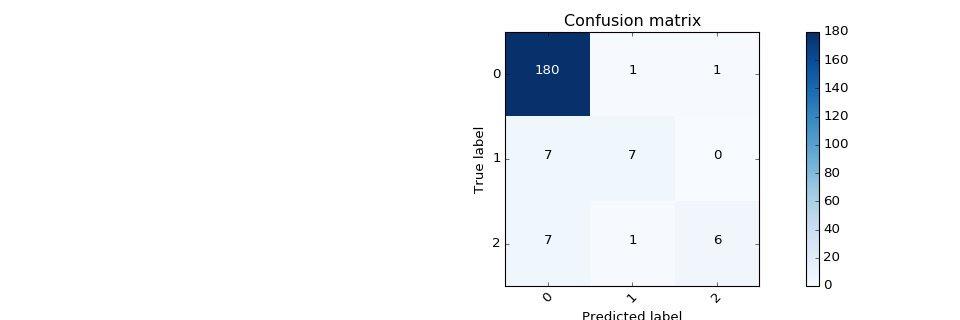

In [17]:
plot_confusion_matrix(neigh,X_pruef,y_pruef,[0,1,2])

### Synthese eines Kausalgraphen aus den kausalen Relevanzen

In [18]:
G_predicted = klassifizierter_Graph(neigh,X_pruef,y_pruef,dfPruef)

In [19]:
G_predicted.draw('G_predicted.png',prog='dot')

In [20]:
show2images(['G_predicted.png','G_pruef.png'],50)

### Nachbearbeitung des Graphen

Durch grundlegende Überlegungen können wir einige der vorhergesagten Kanten als falsch erkennen und aus dem Graphen entfernen. Dopplungen die sowohl A->B als auch B->A verbinden, entfernen wir nach der Regel, dass wir von niedrigeren zu höheren Knoten verknüpfen.

In [21]:
delDoubles(G_predicted)

Entfernte Kanten: [('13', '10')]


In [22]:
G_predicted.draw('G_predicted_postproc.png',prog='dot')

In [23]:
show2images(['G_predicted_postproc.png','G_predicted.png','G_pruef.png'],30)

# Agenten-basierte Nachbearbeitung

## Datensatz erstellen

Die Wahrscheinlichkeiten für einen Übergang zwischen zwei Knoten können mit dem trainierten Klassifizierer vorhergesagt werden. Es gibt drei mögliche Klassen für zwei Knoten A und B: keine Kante (0), A->B (1) oder B->A (2). Der Zusammenhang zwischen dem Index des vorhergesagten Dataframes und den zugehörigen Knoten ist in dem Dataframe "dfPruef" verzeichnet (mit erzeugt durch die Funktion `datensatz_erzeugen`). Wir erstellen daraus einen neuen Dataframe mit den Spalten start und ziel. 

In [24]:
dfMove = dfPruef[['dia1','dia2']].rename(columns={'dia1':'start','dia2':'ziel'})

Die Wahrscheinlichkeiten für "1" fügen wir als "forward" Spalte zu dem Dataframe hinzu.

In [25]:
dfMove['forward'] = [x[1] for x in neigh.predict_proba(X_pruef)]

In [26]:
dfMove.head()

,start,ziel,forward
0,0,1,0.451481
1,0,2,0.725193
2,0,3,0.304584
3,0,4,0.338710
4,0,5,0.304584


Für die Bewegung eines Agenten nutzen wir einen mit Bedingungen reduzierten Dataframe. Zum Beispiel alle Start = 2 Zeilen, für welche die "forward" Wahrscheinlichkeiten größer 0.1 sind, und deren 'ziel' Spalte nicht in [0,2] ist.

In [27]:
dfMove[(~dfMove.ziel.isin([0,2])) & (dfMove.start == 2) & (dfMove.forward > 0.1)]

,start,ziel,forward
30,2,3,0.677824
31,2,4,0.807205
32,2,5,0.677824
35,2,8,0.753079
39,2,12,0.315092


## Agent

Für die Agenten-basierte Modellierung nutzen wir den [mesa Framework](https://github.com/projectmesa/mesa). Agenten werden hier über eine Klasse initialisiert, da je nach Model im Prinzip beliebig viele Agenten parallel ausgeführt werden können und auch miteinander interagieren können. Zur Objekt-orientierten Programmierung siehe zB [Learn Python the Hard Way](https://learnpythonthehardway.org/book/ex40.html).

Der Vorteil einer Definition der Agenten über eine Klasse ist, dass daraus beliebig viele, unabhängige Agenten-Objekte erzeugt werden können. Ähnlich wie beim importieren eines Pakets ( import numpy ) erzeugen wir aus der Klasse der Agenten einen spezifischen Agenten ( agent = TreeAgent() ). Dieser hat dann die in der Klasse definierten Funktionen als mögliche Handlungsvorgaben ( agent.move() ). Über die Konstruktion der Klasse TreeAgent(Agent) werden zudem Eigenschaften der zuvor importierten Klasse Agent aus dem mesa Paket an die neue Agenten-Klasse vererbt. So erhält zum Beispiel jeder Agent automatische eine eindeutige Indentifizierung. 

Der Agent braucht in der Initialisierung drei Informationen: Die eigene Position (self.pos), welche Knoten schon besucht wurden (self.nodes) und was der vorherige Knoten war (self.origin). 
Für den mesa framework muss der Agent eine Funktion step besitzen. Da wir den Kopierbaum ablaufen wollen, definieren wir zudem die Funktion move. 

Für die Bewegung wird aus der Schnittmenge der Liste der möglichen Knoten und der Liste der wahrscheinlichen Knoten ein Ziel zufällig ausgewählt. Ist die Liste der möglichen Knoten leer, wird der Agent auf die Ausgangsposition zurück gesetzt. Der Prozess beginnt wieder von vorn, bis alle Knoten besucht wurden. 

In [28]:
class TreeAgent(Agent):
    """An agent with fixed initial start position."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.pos = 0     # Position
        self.nodes = []  # Besuchte Knoten
        self.origin = 0  # Vorheriger Knoten
        
    def step(self):
        self.move()
    
    def move(self):
        # Bei jedem Schritt wird eine zufällige Schwell-Wahrscheinlichkeit gesetzt.
        rd = random()
        # Die Menge aller möglichen Ziel-Knoten, sind solche die noch nicht besucht wurden und deren Übergangswahrscheinlichkeit größer als rd ist.
        possible_nodes = dfMove[(~dfMove.ziel.isin(self.nodes)) & (dfMove.start == self.pos) & (dfMove.forward > rd)]
        # Mit einem Schritt wird der Wert self.origin auf die aktuelle Postion gesetzt.
        self.origin = self.pos
        # Wenn es mögliche Schritte gibt:
        if possible_nodes.shape[0] > 0:
            # wird zufällig ein bestimmter Schritt ausgewählt,
            new_position = choice(list(possible_nodes.ziel.values))
            # in die Liste der besuchten Knoten geschrieben,
            self.nodes.append(new_position)
            # und als aktuelle Position gesetzt.
            self.pos = new_position
        # Gibt es keine möglichen Schritte mehr, wird die Position auf 0 gesetzt
        else:
            self.pos = 0
            self.nodes = []

## Modell
Auch das Modell, welches das Verhalten der Agenten steuert, ist als Klasse definiert. Zur Initialisierung werden nur die Anzahl der Agenten als Parameter übergeben. Für diese Anzahl werden in einer Schleife Agenten-Objekte erzeugt und in die Liste der auszuführenden Prozesse (Scheduler) eingetragen.

Durch das vererben der Model Klasse aus dem mesa Paket gitb es vordefinierte Routinen für das Sammeln von Daten der Agenten. Uns interessiert die Postion der Agenten in jedem einzelnen Schritt. Diese erhalten wir über ```self.datacollector = ...```

Auch die Modell-Klasse hat eine step Funktion. Hier wird zum einen der Datensatz an den Collector geschickt und zum anderen der nächste Schritt des Schedulers initialisiert. 

In [29]:
class TreeModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.running = True
        
        # Erzeuge Agenten-Objekte und setze diese auf den Scheduler
        for i in range(self.num_agents):
            a = TreeAgent(i, self)
            self.schedule.add(a)
        
        # Die Position jedes Agenten soll in jedem Schritt aufgezeichnet werden 
        # Um später einen Graphen erzeugen zu können, lassen wir ein Tupel aus vorheriger und aktueller Position aufzeichnen.
        self.datacollector = DataCollector(
            agent_reporters={'Position': lambda a: (a.origin,a.pos)})
            
    # Sammle Daten und gehe den nächsten Schritt im Scheduler
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Ausführen der Agenten-Modellierung

Da der Agent während der Simulation auf den Ursprung zurück gesetzt werden kann, initialisieren wir das Model mit nur einem Agenten.

In [30]:
# Anzahl der Agenten
NAgents = 100
# Anzahl der auszuführenden Schritte
NSteps = 30

In [31]:
model = TreeModel(NAgents)

Nun führen wir die Schritte aus.

In [32]:
for i in range(NSteps):
    model.step()

Das mesa Paket erlaubt es uns, die Daten des Agenten direkt als Dataframe auszulesen.

In [33]:
agent_pos = model.datacollector.get_agent_vars_dataframe()
agent_pos.head()

Position
Step AgentID         
0    0         (0, 0)
     1         (0, 0)
     2         (0, 0)
     3         (0, 0)
     4         (0, 0)

Da der Agent während eines Laufs wiederholt auf die Ursprungsposition zurück gesetzt wird, müssen wir solche Kanten entfernen, die an der zweiten Stelle eine 0 haben. 

In [34]:
posList = [x for x in agent_pos.Position.values if x[1] != 0]

Wir zählen nun die Häufigkeit der einzelnen Knoten, um so ein Gewicht zu vergeben.

In [35]:
edges = Counter(posList)

In [36]:
print('Maximal counts: ', maxCounts(edges), '; Mean:', meanCounts(edges), '; Mean minus std/4":',meanDeviation(edges))

Maximal counts:  1400 ; Mean: 129.89743589743588 ; Mean minus std/4": 72.737690254


Mit dem networkx Paket erzeugen wir einen gerichteten Graphen und fügen die vom Agenten gesammelten Kanten hinzu.

In [37]:
labels = {i:i for i in range(0,15)}

graph = nx.DiGraph()

In [38]:
edge_weight = [(x[0],x[1],y) for x,y in edges.items()]

In [39]:
edge_high = [graph.add_edge(x,y,weight=z) for x,y,z in edge_weight]

Wir entfernen nun solche Kanten, die auf einen bereits belegten Knoten verweisen. Dafür überprüfen wir graph.in_degree(Knoten). Ist dieses größer als 1 schreiben wir die zugehörigen Kanten in eine Liste. 

In [40]:
listed = [ed for ed in graph.edges(data=True) if graph.in_degree(ed[1]) > 1]
listZiele = set([x[1] for x in listed])

kanten = []
for i in listZiele:
    iList = [x for x in listed if x[1] == i]
    kanten.append(iList)

In [41]:
kanten[:2]

[[(0, 2, {'weight': 1400}), (8, 2, {'weight': 70})],
 [(0, 3, {'weight': 197}),
  (1, 3, {'weight': 48}),
  (2, 3, {'weight': 204}),
  (4, 3, {'weight': 21}),
  (5, 3, {'weight': 60}),
  (8, 3, {'weight': 14})]]

Aus der Liste der möglichen Kanten wählen wir die mit dem größten Gewicht. Dafür sortieren wir die Listen nach dem Gewicht und entfernen das letzte, größte Element. 

In [42]:
toRemove = [sorted(x,key=lambda r: r[2]['weight'])[:-1] for x in kanten]
edges2remove = [x for y in toRemove for x in y]
edges2remove[:10]

[(8, 2, {'weight': 70}),
 (8, 3, {'weight': 14}),
 (4, 3, {'weight': 21}),
 (1, 3, {'weight': 48}),
 (5, 3, {'weight': 60}),
 (0, 3, {'weight': 197}),
 (8, 4, {'weight': 20}),
 (5, 4, {'weight': 79}),
 (0, 4, {'weight': 195}),
 (8, 5, {'weight': 21})]

Die übrigen Kanten entfernen wir aus dem Graphen.

In [43]:
graph.remove_edges_from(edges2remove)

Das Layout wir über das graphviz Programm 'dot' erzeugt.

In [44]:
pos=nx.drawing.nx_agraph.graphviz_layout(graph,prog='dot')

Nun zeichnen wir den Graphen. Die Dicke der Verbindungen spiegelt das Gewicht der Verbindung wieder.

<IPython.core.display.Javascript object>


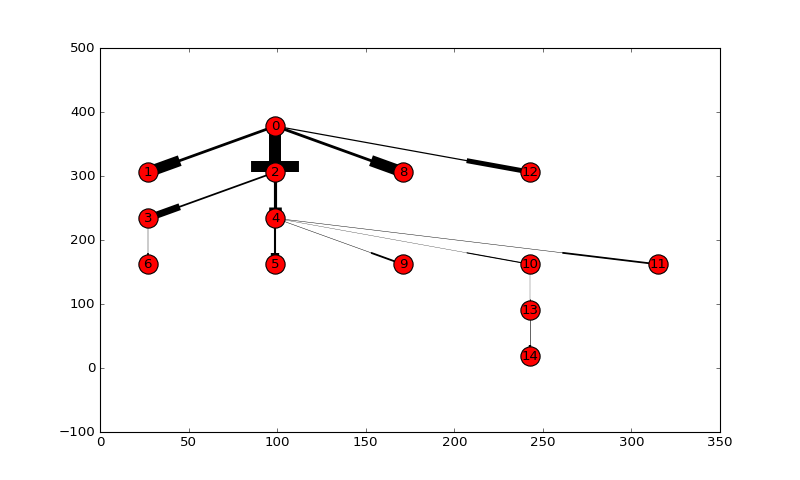

In [45]:
fig,ax = plt.subplots(1,1,figsize=(10, 6),sharey=True,sharex=True)

for edg in graph.edges(data=True):
    width_edge = edg[2]['weight']/meanCounts(edges)
    nx.draw_networkx_edges(graph,pos=pos,edgelist=[edg],width=width_edge)
nx.draw_networkx_labels(graph,pos=pos);
nx.draw_networkx_nodes(graph,pos,node_size=300);

Um die Hierachie sichtbar zu machen, nutzen wir wieder das Graphviz Programm. 

In [46]:
agent_graph=nx.nx_agraph.to_agraph(graph)

In [47]:
agent_graph.draw('agent_graph.png',prog='dot')
show2images(['agent_graph.png','G_predicted.png','G_pruef.png'],30)

### Nicht-gefundenen Kanten

Werden Kanten nicht gefunden, kann das an einer geringen Übergangswahrscheinlichkeit im Klassifikator liegen. Diese kann mit dem Dataframe abgerufen werden.

In [48]:
def showSubFrame(start,stop):
    return (dfMove.loc[dfMove.start == start]).loc[dfMove.ziel == stop]

In [49]:
showSubFrame(0,2)

,start,ziel,forward
1,0,2,0.725193
